# Data Management

## Imports

In [2]:
import json
import numpy as np
import os
import pandas as pd
import boto3  # boto3: high-level API
import random
import language_tool_python
import sys
sys.path.append("../")

from botocore import UNSIGNED  # botocore: lower-level API and components
from botocore.config import Config
from IPython.display import Image
from pyngrok import ngrok
from onnxruntime import InferenceSession
from transformers import CLIPProcessor
from typing import Optional

from question_answer.metadata.shared import DATA_DIRNAME, DOWNLOADED_DATA_DIRNAME

# tool = language_tool_python.LanguageTool('en-US')

In [3]:
ARTIFACT_PATH = "../question_answer/artifacts/"
ANN_PATH = ARTIFACT_PATH + "coco_annotations/"
CAPTIONS = ANN_PATH + "captions_train2014.json"
PREPROCESSED = ANN_PATH + "admirer-pica.json"

SIMILARITY_PATH = ARTIFACT_PATH + "coco_clip_new/"
IDXS = SIMILARITY_PATH + "okvqa_qa_line2sample_idx_train2014.json"
QUESTION_FEATURES = SIMILARITY_PATH + "coco_clip_vitb16_train2014_okvqa_question.npy"
IMG_FEATURES = SIMILARITY_PATH + "coco_clip_vitb16_train2014_okvqa_convertedidx_image.npy"

clip_processor = ARTIFACT_PATH + "transformers/openai/clip-vit-base-patch16"
clip_onnx = ARTIFACT_PATH + "onnx/clip.onnx"

In [4]:
!zenml integration install great_expectations s3 dash -y

!zenml artifact-store register s3_store \
    --flavor=s3 \
    --path=s3://admirer-pica-zenml-greatexpectations

!zenml data-validator register great_expectations \
    --flavor=great_expectations

!zenml stack register admirer-pica_stack \
    -o default \
    -a s3_store \
    -dv great_expectations \
    --set

⠋ Installing integrations.....
⠋ Registering artifact store 's3_store'...
⠙ Registering artifact store 's3_store'...
⠹ Registering artifact store 's3_store'...
⠸ Registering artifact store 's3_store'...
⠼ Registering artifact store 's3_store'...
⠴ Registering artifact store 's3_store'...
⠦ Registering artifact store 's3_store'...
⠧ Registering artifact store 's3_store'...
⠇ Registering artifact store 's3_store'...
⠏ Registering artifact store 's3_store'...
⠋ Registering artifact store 's3_store'...
⠙ Registering artifact store 's3_store'...
⠸ Registering artifact store 's3_store'...
⠼ Registering artifact store 's3_store'...
Using the default local database.
⠼ Registering artifact store 's3_store'...
Running with active project: 'default' (repository)
⠼ Registering artifact store 's3_store'...
Running with active stack: 'admirer-pica_stack' (repository)
⠼ Registering artifact store 's3_store'...
⠴ Registering artifact store 's3_store'...
⠦ Registering artifact store 's3_store'...
⠧ Reg

In [5]:
from great_expectations.checkpoint.types.checkpoint_result import (  # type: ignore[import]
    CheckpointResult,
)

from zenml.integrations.constants import GREAT_EXPECTATIONS, SKLEARN
from zenml.integrations.great_expectations.steps import (
    GreatExpectationsProfilerParameters,
    GreatExpectationsProfilerStep,
    GreatExpectationsValidatorParameters,
    GreatExpectationsValidatorStep,
)
from zenml.integrations.great_expectations.visualizers import (
    GreatExpectationsVisualizer,
)
from zenml.pipelines import pipeline
from zenml.steps import BaseParameters, Output, step


from zenml.steps import (
    STEP_ENVIRONMENT_NAME,
    StepEnvironment,
)
from zenml.environment import Environment
from typing import cast


from zenml.config import DockerSettings


from zenml.post_execution import get_pipeline

## Exploration

In [6]:
s3_bucket_name = "admirer-pica"  # objects are placed into buckets
s3_directory_path = "images"  # buckets can contain "folders" for organization
# we combine this information into a base URL format for the data:
s3_url = f"https://{s3_bucket_name}.s3.us-west-1.amazonaws.com/{s3_directory_path}"
s3_url

'https://admirer-pica.s3.us-west-1.amazonaws.com/images'

In [7]:
person_idx = 1
image_idx = 1
img_url = f"{s3_url}/{str(person_idx).zfill(3)}_{str(image_idx).zfill(2)}.png"
print(img_url)
Image(url=img_url, width=360)

https://admirer-pica.s3.us-west-1.amazonaws.com/images/001_01.png


In [8]:
ADMIRER_RAW_DATA_DIRNAME = DATA_DIRNAME / "raw" / s3_bucket_name
ADMIRER_DL_DATA_DIRNAME = DOWNLOADED_DATA_DIRNAME / s3_bucket_name / s3_directory_path

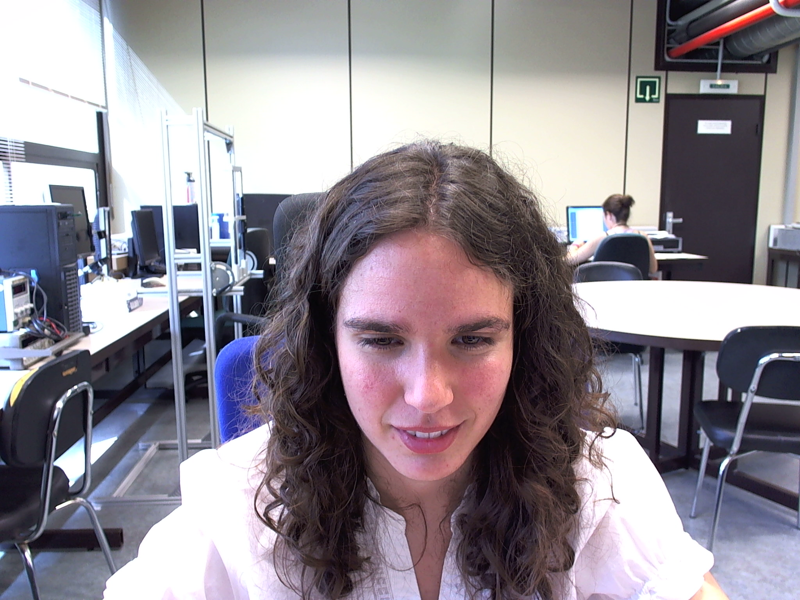

In [9]:
# spin up a client for communicating with s3 without authenticating ("UNSIGNED" activity)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

!mkdir -p {ADMIRER_DL_DATA_DIRNAME}

s3.download_file(
    s3_bucket_name, s3_directory_path + "/001_01.png", f"{ADMIRER_DL_DATA_DIRNAME}/001_01.png")

Image(filename=f"{ADMIRER_DL_DATA_DIRNAME}/001_01.png", width=720)

In [10]:
s3_resource = boto3.resource('s3', config=Config(signature_version=UNSIGNED))


def download_s3_folder(bucket_name: str, s3_folder: str, local_dir: Optional[str] = None):
    """Download the contents of a folder on S3, recursively.

    Parameters
    ----------
    bucket_name: the name of the s3 bucket
    s3_folder: the folder path in the s3 bucket
    local_dir: a relative or absolute directory path in the local file system
    """
    # from https://stackoverflow.com/questions/49772151/download-a-folder-from-s3-using-boto3
    bucket = s3_resource.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=s3_folder):
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
        
        
download_s3_folder(s3_bucket_name, s3_directory_path, ADMIRER_DL_DATA_DIRNAME)

In [ ]:
!find {ADMIRER_DL_DATA_DIRNAME} | head -n 20

/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/040_12.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/011_10.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/012_08.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/022_12.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/081_03.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/057_10.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/063_02.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/010_05.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/021_01.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/049_08.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/095_09.png
/home/alejhii/repos/admirer/data/downloaded/admirer-pica/images/048_10.png
/home/alejhii/repos/admirer/data/dow

## Local Annotation
- Note: not used since annotations obtained with Scale.ai, but here for future use

### Configuring and connecting to the web server
- In some cases, you might have to sign up for an account and use that to login

In [ ]:
username = "admirer@localhost"
password = "moonshine"

%env LABEL_STUDIO_USERNAME={username}
%env LABEL_STUDIO_PASSWORD={password}

In [ ]:
config_file = ngrok.conf.DEFAULT_NGROK_CONFIG_PATH
config_file_exists =  os.path.exists(config_file)
config_file_contents = !cat {config_file}

auth_token_found = config_file_exists \
    and config_file_contents \
    and "authtoken" in config_file_contents[0] \
    and ": exit" not in config_file_contents  # state if interrupted

if not auth_token_found:
    print("Enter your ngrok auth token, which can be copied from https://dashboard.ngrok.com/auth")
    !ngrok authtoken {getpass.getpass()}

In [ ]:
LABEL_STUDIO_PORT = 8081
%env LABEL_STUDIO_PORT={LABEL_STUDIO_PORT}

https_tunnel = ngrok.connect(LABEL_STUDIO_PORT, bind_tls=True)
print(https_tunnel)

In [ ]:
# Run this in the terminal
"""
python3 -m venv label-env \ 
    conda deactivate \
    source label-env/bin/activate \
    pip install -qqq label-studio \
    export LABEL_STUDIO_PORT=8081 \
    label-studio start --port=$LABEL_STUDIO_PORT \
"""

In [ ]:
print(https_tunnel.public_url)
print("u:", username)
print("p:", password)

### Uploading Data

In [ ]:
img_urls = []
for person_idx in range(1, 104):
    for image_idx in range(1, 13):
        img_urls.append(f"{s3_url}/{str(person_idx).zfill(3)}_{str(image_idx).zfill(2)}.png")

df = pd.DataFrame(img_urls, columns=["webcam"])
df.to_csv(str(ADMIRER_RAW_DATA_DIRNAME / "manifest.csv"), index=False)

In [ ]:
print(ADMIRER_RAW_DATA_DIRNAME / "manifest.csv")
!cat {ADMIRER_RAW_DATA_DIRNAME}/manifest.csv | head -n 10

### Teardown

In [ ]:
# Run in the terminal
"""
deactivate /
    conda activate admirer
"""

## Preprocessing
- Run after annotations downloaded as .json file to ADMIRER_RAW_DATA_DIRNAME / annotated_data.json

### Load Data
- Depends on Annotation Source

#### LabelStudio

In [ ]:
with open(ADMIRER_RAW_DATA_DIRNAME / "annotated_data.json", "r") as f: data = json.load(f)

ids = data['id']
s3_links = data['webcam']
captions = data['caption']
list_tags = data['tags']
questions = data['question']
answers = data['answer']

ids[0], s3_links[0], captions[0], list_tags[0], questions[0], answers[0]

#### Scale

In [ ]:
ids = []
s3_links = []
captions = []
list_tags = []
questions = []
answers = []

with open(ADMIRER_RAW_DATA_DIRNAME / "annotated_data.json", "r") as f: data = json.load(f)
for task in data: 
    ids.append(task['task_id'])
    s3_links.append(task['attachmentS3Downloads'][0]['s3URL'])
    temp = task['response']['global_attributes']
    captions.append(temp['caption'])
    list_tags.append(temp['tags'])
    questions.append(temp['question'])
    answers.append(temp['answer'])

ids[0], s3_links[0], captions[0], list_tags[0], questions[0], answers[0]

### Correct Grammar Mistakes

In [ ]:
captions = [tool.correct(caption).strip() for caption in captions]
list_tags = [tool.correct(tag).strip() for tag in list_tags]
questions = [tool.correct(question).strip() for question in questions]
answers = [tool.correct(answer).strip() for answer in answers]

func = lambda s: s[:1].lower() + s[1:] if s else ''
list_tags = [func(tag) for tag in list_tags]
answers = [func(answer) for answer in answers]

captions[0], list_tags[0], questions[0], answers[0]

### Adding image and question id columns

In [ ]:
keys = []

coco_caption = json.load(open(CAPTIONS, "r"))
if isinstance(coco_caption, dict):
    coco_caption = coco_caption["annotations"]
for sample in coco_caption:
    if sample["image_id"] not in keys: keys.append(sample["image_id"])      

len(keys)

In [ ]:
image_ids = []
question_ids = []
num_gen = 0

while num_gen<len(df):
    rand_num = random.randint(10000, 999999)
    if rand_num not in keys:
        image_ids.append(rand_num)
        question_ids.append(str(rand_num) + '5')
        num_gen+=1
        
print(len(df), len(image_ids), len(question_ids), image_ids[0], question_ids[0])

### Saving preprocessed data

In [ ]:
df = pd.DataFrame(list(zip(image_ids,
                           question_ids,
                           s3_links,
                           captions,
                           list_tags,
                           questions,
                           answers)), columns=["image_id",
                                               "question_id",
                                               "webcam",
                                               "caption",
                                               "tags",
                                               "question",
                                               "answer"])
df.to_json(PREPROCESSED)

### Updating Idxs + Feature Artifact Files (coco_clip_new)

In [ ]:
train_idx = json.load(
    open(
        IDXS,
        "r",
    )
)
train_feature = np.load(QUESTION_FEATURES)
image_train_feature = np.load(
    IMG_FEATURES
)
train_feature.shape, len(train_idx), image_train_feature.shape

In [ ]:
combine_ids = [str(image_id) + "<->" + str(question_id) for image_id, question_id in zip(list(df['image_id']), list(df['question_id']))]
num_idx = list(range(9009, 9009+len(df)))
num_idx = list(map(str, num_idx))
idx_add = dict(zip(num_idx, combine_ids))
train_idx.update(idx_add)
len(train_idx)

In [ ]:
clip_session = InferenceSession(str(clip_onnx))
clip_processor = CLIPProcessor.from_pretrained(clip_processor)

data_path = DOWNLOADED_DATA_DIRNAME / "admirer-pica/images/"
images = [str(data_path / f) for f in os.listdir(str(data_path)) if os.path.isfile(os.path.join(str(data_path),f))]
images_pil = []

for image in images:
    image_pil = Image.open(image)
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert(mode="RGB")
    images_pil.append(image_pil)
   
inputs = clip_processor(text=list(df['question']), images=images_pil, return_tensors="np", padding=True)
outputs = clip_session.run(
    output_names=["logits_per_image", "logits_per_text", "text_embeds", "image_embeds"], input_feed=dict(inputs)
)

train_feature = np.concatenate((train_feature, outputs[2]))
image_train_feature = np.concatenate((image_train_feature, outputs[3]))
train_feature.shape, image_train_feature.shape

In [ ]:
with open(IDXS, "w") as f: json.dump(train_idx, f)
with open(QUESTION_FEATURES, 'wb') as f: np.save(f, train_feature)
with open(IMG_FEATURES, 'wb') as f: np.save(f, image_train_feature)

## Data Validation

### Define ZenML Steps


In [ ]:
class DataLoaderParameters(BaseParameters):
    reference_data: bool = True

@step
def importer(
        params: DataLoaderParameters,
) -> Output(dataset=pd.DataFrame, condition=bool):
    # Load labeled projects
    df = pd.read_json(PREPROCESSED)
    return df, params.reference_data

In [ ]:
# instantiate a builtin Great Expectations data profiling step
ge_profiler_params = GreatExpectationsProfilerParameters(
    expectation_suite_name="admirer-pica",
    data_asset_name="admirer-pica_test_df",
)
ge_profiler_step = GreatExpectationsProfilerStep(params=ge_profiler_params)


# instantiate a builtin Great Expectations data validation step
ge_validator_params = GreatExpectationsValidatorParameters(
    expectation_suite_name="admirer-pica",
    data_asset_name="admirer-pica_test_df",
)
ge_validator_step = GreatExpectationsValidatorStep(params=ge_validator_params)

In [ ]:
@step
def analyze_result(
    result: CheckpointResult,
) -> str:
    """Analyze the Great Expectations validation result and return a true/false value indicating
    whether it passed or failed."""
    step_env = cast(StepEnvironment, Environment()[STEP_ENVIRONMENT_NAME])
    pipeline_name = step_env.pipeline_name
    pipeline_run_id = step_env.pipeline_run_id
    step_name = step_env.step_name
    pipeline_context = f"Pipeline {pipeline_name}, with run {pipeline_run_id}, in step {step_name} produced the following output:\n\n"
    if result.success:
        message = pipeline_context + "Great Expectations data validation was successful!"
    else:
        message = pipeline_context + "Great Expectations data validation failed!"
    print(message)
    return message

### Define ZenML Pipelines

In [ ]:
docker_settings = DockerSettings(required_integrations=[GREAT_EXPECTATIONS])

@pipeline(enable_cache=False, settings={"docker": docker_settings})
def profiling_pipeline(
    importer, profiler
):
    """Data profiling pipeline for Great Expectations.

    The pipeline imports a reference dataset from a source then uses the builtin
    Great Expectations profiler step to generate an expectation suite (i.e.
    validation rules) inferred from the schema and statistical properties of the
    reference dataset.

    Args:
        importer: reference data importer step
        profiler: data profiler step
    """
    dataset, _ = importer()
    profiler(dataset)

In [ ]:
@pipeline(enable_cache=False, settings={"docker": docker_settings})
def validation_pipeline(
    importer, validator, checker
):
    """Data validation pipeline for Great Expectations.

    The pipeline imports a test data from a source, then uses the builtin
    Great Expectations data validation step to validate the dataset against
    the expectation suite generated in the profiling pipeline.

    Args:
        importer: test data importer step
        validator: dataset validation step
        checker: checks the validation results
    """
    dataset, condition = importer()
    results = validator(dataset, condition)
    message = checker(results)

### Run the pipelines

In [ ]:
profiling_pipeline(
    importer=importer(params=DataLoaderParameters(reference_data=True)),
    profiler=ge_profiler_step,
).run()

In [ ]:
validation_pipeline(
    importer=importer(params=DataLoaderParameters(reference_data=True)),
    validator=ge_validator_step,
    checker=analyze_result(),
).run()

### Post execution workflow

In [ ]:
def start_pipeline_visualizer(name: str):

    from zenml.integrations.dash.visualizers.pipeline_run_lineage_visualizer import (
        PipelineRunLineageVisualizer,
    )

    latest_run = get_pipeline(name).runs[-1]
    PipelineRunLineageVisualizer().visualize(latest_run)

In [ ]:
def visualize_results(pipeline_name: str, step_name: str) -> None:
    pipeline = get_pipeline(pipeline_name)
    last_run = pipeline.runs[-1]
    step = last_run.get_step(step=step_name)
    GreatExpectationsVisualizer().visualize(step)

In [ ]:
# start_pipeline_visualizer("profiling_pipeline")

In [ ]:
# start_pipeline_visualizer("validation_pipeline")

In [ ]:
# visualize_results("profiling_pipeline", "profiler")

In [ ]:
# visualize_results("validation_pipeline", "validator")